# Hough

## Funções e Execução separada (exibição ruim)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import Optional, Tuple, List, Any

In [2]:
def load_image(path: str) -> np.ndarray:
    """
    Lê uma imagem do caminho e retorna imagem BGR.
    Lança FileNotFoundError ou ValueError se falhar.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"Arquivo não encontrado: {path}")
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Falha ao carregar a imagem (pode estar corrompida): {path}")
    return img

In [3]:
def preprocess_for_hough(
    img_bgr: np.ndarray,
    invert: bool = True,
    equalize: bool = True,
    blur_ksize: int = 5
) -> np.ndarray:
    """
    Converte para cinza e aplica:
      - inversão (se invert=True),
      - equalização (se equalize=True),
      - filtro mediano com kernel blur_ksize.
    Retorna a imagem pré-processada (grayscale).
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    if invert:
        gray = cv2.bitwise_not(gray)
    if equalize:
        gray = cv2.equalizeHist(gray)
    if blur_ksize is not None and blur_ksize > 1:
        # kernel do medianBlur precisa ser ímpar
        k = blur_ksize if blur_ksize % 2 == 1 else blur_ksize + 1
        gray = cv2.medianBlur(gray, k)
    return gray

In [4]:
def detect_hough_circles(
    gray_img: np.ndarray,
    dp: float = 1.2,
    minDist: float = 20,
    param1: float = 50,
    param2: float = 25,
    minRadius: int = 3,
    maxRadius: int = 40
) -> Optional[np.ndarray]:
    """
    Executa cv2.HoughCircles com parâmetros fornecidos.
    Retorna array de círculos (Nx3) ou None.
    """
    circles = cv2.HoughCircles(
        gray_img,
        cv2.HOUGH_GRADIENT,
        dp=dp,
        minDist=minDist,
        param1=param1,
        param2=param2,
        minRadius=minRadius,
        maxRadius=maxRadius
    )
    return circles

In [5]:
def draw_circles_on_image(img_bgr: np.ndarray, circles: Optional[np.ndarray]) -> np.ndarray:
    """
    Retorna cópia da imagem com círculos desenhados (verde = contorno, vermelho = centro).
    """
    out = img_bgr.copy()
    if circles is None:
        return out
    circles_uint = np.uint16(np.around(circles))
    for (x, y, r) in circles_uint[0, :]:
        cv2.circle(out, (x, y), r, (0, 255, 0), 2)
        cv2.circle(out, (x, y), 2, (0, 0, 255), 3)
    return out

In [6]:
def show_image(img_bgr: np.ndarray, title: str = "", figsize: Tuple[int,int] = (6,6)) -> None:
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

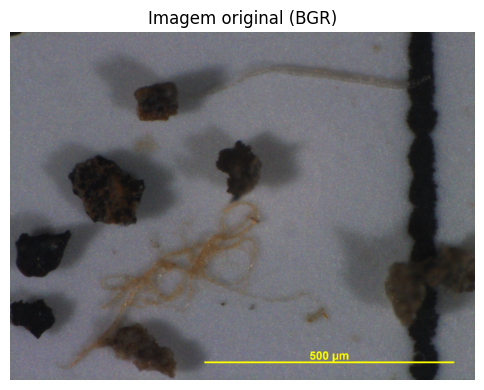

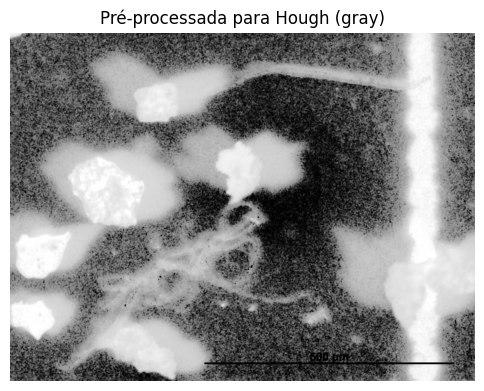

1.2
20
50
25
60
3
5389 círculos detectados (Hough).


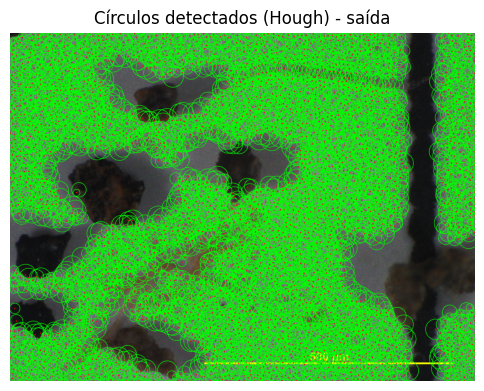

2.2
25
55
30
65
4
4085 círculos detectados (Hough).


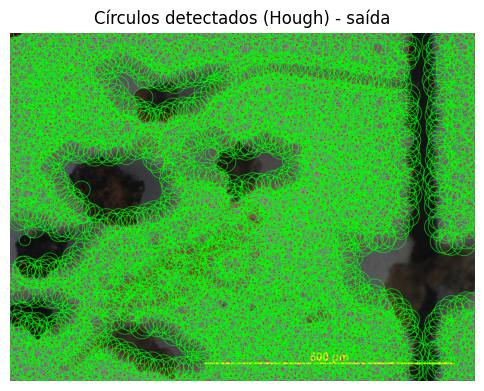

3.2
30
60
35
70
5
2954 círculos detectados (Hough).


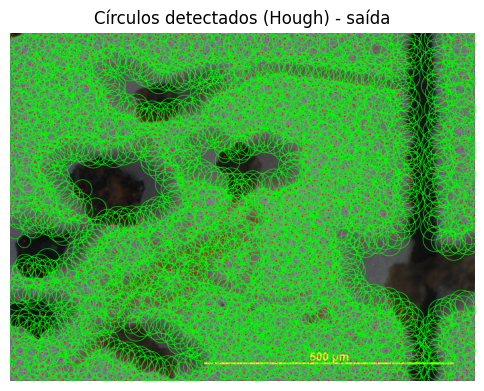

4.2
35
65
40
75
6
2152 círculos detectados (Hough).


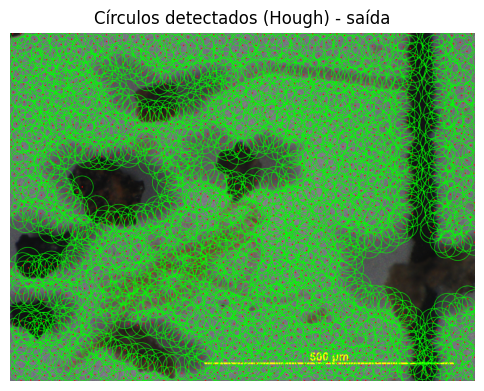

5.2
40
70
45
80
7
1681 círculos detectados (Hough).


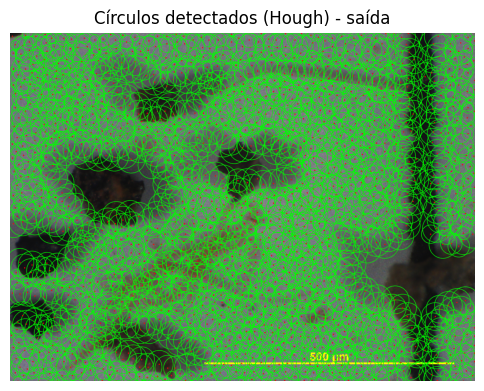

6.2
45
75
50
85
8
1266 círculos detectados (Hough).


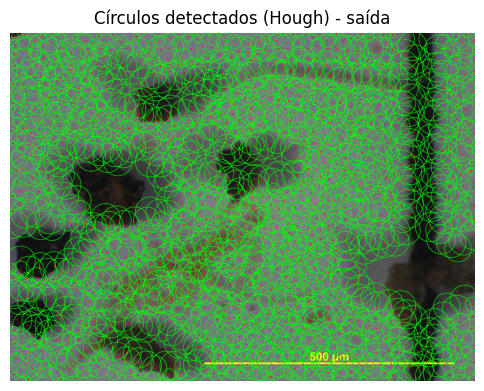

7.2
50
80
55
90
9
1055 círculos detectados (Hough).


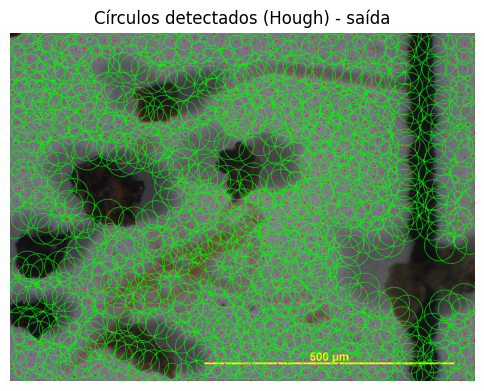

8.2
55
85
60
95
10
839 círculos detectados (Hough).


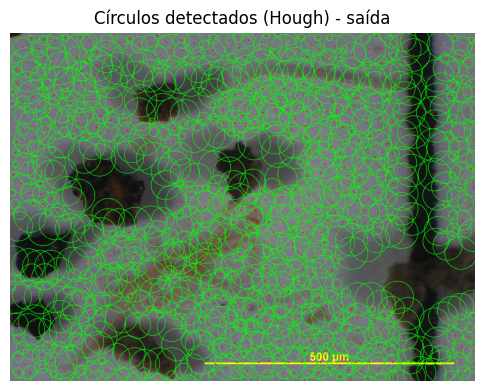

9.2
60
90
65
100
11
631 círculos detectados (Hough).


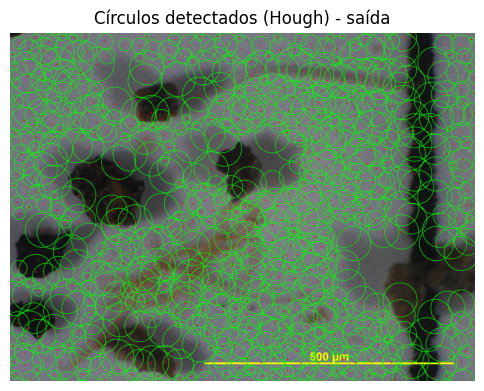

10.2
65
95
70
105
12
529 círculos detectados (Hough).


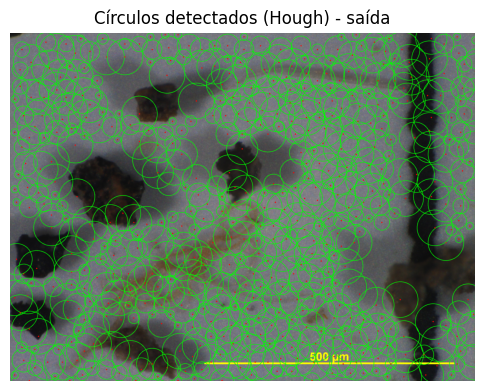

11.2
70
100
75
110
13
431 círculos detectados (Hough).


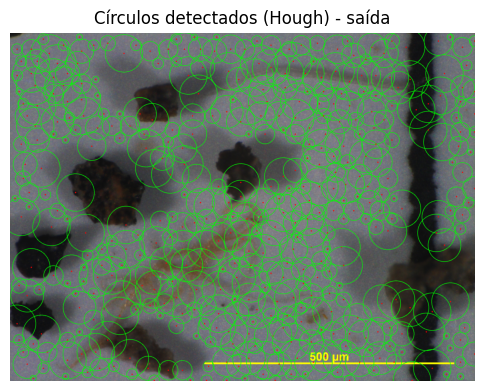

In [7]:
# Parâmetros
img_path = r"..\data\CNN_P1_L1_T1_M1_LG_Q8_150x.jpg"

# Carregar
img = load_image(img_path)
show_image(img, "Imagem original (BGR)")

# Pré-processar
gray_pp = preprocess_for_hough(img, invert=True, equalize=True, blur_ksize=5)
plt.figure(figsize=(6,6))
plt.title("Pré-processada para Hough (gray)")
plt.imshow(gray_pp, cmap='gray')
plt.axis('off')
plt.show()

for i in range(0, 101, 10):
    dp_range = 1.2 + (i*0.1)
    print(dp_range)
    minDist_range = int(20 + (i*0.5))
    print(minDist_range)
    param1_range = int(50 + (i*0.5))
    print(param1_range)
    param2_range = int(25 + (i*0.5))
    print(param2_range)
    maxRadius_range = int(60 + (i*0.5) )
    print(maxRadius_range)
    minRadius_range = int(3 + (i*0.1))
    print(minRadius_range)

    circles = detect_hough_circles(
        gray_pp,
        dp=dp_range, minDist=minDist_range,
        param1=param1_range, param2=param2_range,
        minRadius=minRadius_range, maxRadius=maxRadius_range
    )

    if circles is None:
        print("Nenhum círculo identificado pelo Hough com os parâmetros atuais.")
    else:
        print(f"{circles.shape[1]} círculos detectados (Hough).")

    # Desenhar e mostrar
    out = draw_circles_on_image(img, circles)
    show_image(out, "Círculos detectados (Hough) - saída")

## Tudo junto (interativo)

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, fixed

# --- Funções auxiliares ---

def preprocess_image_for_hough(img, blur_ksize=5, clahe_clip=2.0, clahe_grid=8, invert=False):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Equalização adaptativa de contraste
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(clahe_grid, clahe_grid))
    gray_eq = clahe.apply(gray)

    # Suavização para reduzir ruído
    gray_blur = cv2.GaussianBlur(gray_eq, (blur_ksize, blur_ksize), 0)

    # Inversão opcional
    if invert:
        gray_blur = cv2.bitwise_not(gray_blur)

    return gray_blur

def detect_hough_circles(gray, dp=1.2, minDist=30, param1=100, param2=40, minRadius=5, maxRadius=60):
    circles = cv2.HoughCircles(
        gray, cv2.HOUGH_GRADIENT, dp=dp, minDist=minDist,
        param1=param1, param2=param2,
        minRadius=minRadius, maxRadius=maxRadius
    )
    return circles

def draw_circles_on_image(img, circles):
    output = img.copy()
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            center = (i[0], i[1])
            radius = i[2]
            cv2.circle(output, center, radius, (0, 255, 0), 2)   # contorno verde
            cv2.circle(output, center, 2, (0, 0, 255), 3)        # centro vermelho
    return output


# --- Função principal interativa ---

def interactive_hough_detection(img):

    @interact(
        blur_ksize=IntSlider(value=5, min=3, max=15, step=2, description="Blur ksize"),
        clahe_clip=FloatSlider(value=2.0, min=1.0, max=5.0, step=0.5, description="CLAHE clip"),
        clahe_grid=IntSlider(value=8, min=4, max=16, step=2, description="CLAHE grid"),
        invert=(False, True),
        dp=FloatSlider(value=1.2, min=1.0, max=2.0, step=0.1, description="dp"),
        minDist=IntSlider(value=30, min=10, max=100, step=5, description="minDist"),
        param1=IntSlider(value=100, min=50, max=200, step=10, description="param1"),
        param2=IntSlider(value=40, min=10, max=100, step=5, description="param2"),
        minRadius=IntSlider(value=5, min=0, max=50, step=2, description="minRadius"),
        maxRadius=IntSlider(value=60, min=20, max=200, step=5, description="maxRadius")
    )
    def update(blur_ksize, clahe_clip, clahe_grid, invert,
               dp, minDist, param1, param2, minRadius, maxRadius):

        # Pré-processamento
        gray_pp = preprocess_image_for_hough(
            img,
            blur_ksize=blur_ksize,
            clahe_clip=clahe_clip,
            clahe_grid=clahe_grid,
            invert=invert
        )

        # Detecção de círculos
        circles = detect_hough_circles(
            gray_pp,
            dp=dp,
            minDist=minDist,
            param1=param1,
            param2=param2,
            minRadius=minRadius,
            maxRadius=maxRadius
        )

        # Desenho dos círculos detectados
        output = draw_circles_on_image(img, circles)

        # Exibição
        fig, axes = plt.subplots(1, 3, figsize=(15, 6))
        axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Imagem Original")
        axes[0].axis("off")

        axes[1].imshow(gray_pp, cmap='gray')
        axes[1].set_title("Imagem Pré-processada (para Hough)")
        axes[1].axis("off")

        axes[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        axes[2].set_title("Círculos Detectados")
        axes[2].axis("off")

        plt.show()


img_path = r"..\data\CNN_P1_L1_T1_M1_LC_Q9_100x.jpg"
img = cv2.imread(img_path)

interactive_hough_detection(img)


interactive(children=(IntSlider(value=5, description='Blur ksize', max=15, min=3, step=2), FloatSlider(value=2…

# Morfologia

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Checkbox, fixed


# ======================================================
# Funções do pipeline morfológico (reutilizando as anteriores)
# ======================================================

def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Imagem não encontrada: {image_path}")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, gray


def adaptive_binarization(gray, block_size=11, C=3, inv=True):
    thresh_type = cv2.THRESH_BINARY_INV if inv else cv2.THRESH_BINARY
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresh_type, block_size, C
    )
    return binary


def morphological_processing(binary, kernel_size=7):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    return opened, closed


def detect_circles_morph(closed, img_original, min_radius=5, max_radius=50):
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    output = img_original.copy()
    for cnt in contours:
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        if min_radius < radius < max_radius:
            cv2.circle(output, (int(x), int(y)), int(radius), (255, 0, 0), 2)
    return output, contours


# ======================================================
# Função de visualização com parâmetros ajustáveis
# ======================================================

def interactive_morphological_detection(
    image_path,
    block_size=11,
    C=3,
    inv=True,
    kernel_size=7,
    min_radius=5,
    max_radius=50,
    show_steps=True
):
    """
    Interface interativa para detecção morfológica de círculos.
    """
    img, gray = load_image(image_path)
    binary = adaptive_binarization(gray, block_size, C, inv)
    opened, closed = morphological_processing(binary, kernel_size)
    output, contours = detect_circles_morph(closed, img, min_radius, max_radius)

    # Visualização
    ncols = 3 if show_steps else 1
    plt.figure(figsize=(5 * ncols, 6))

    if show_steps:
        plt.subplot(1, 3, 1)
        plt.title("Imagem em tons de cinza")
        plt.imshow(gray, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Imagem após morfologia")
        plt.imshow(closed, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
    else:
        plt.subplot(1, 1, 1)
    
    plt.title("Círculos detectados (método morfológico)")
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# ======================================================
# Interface interativa com sliders e checkboxes
# ======================================================

def create_morph_interface(image_path):
    interact(
        interactive_morphological_detection,
        image_path=fixed(image_path),
        block_size=IntSlider(value=11, min=3, max=51, step=2, description='Block Size'),
        C=IntSlider(value=3, min=0, max=10, step=1, description='C'),
        inv=Checkbox(value=True, description='Inverter binarização'),
        kernel_size=IntSlider(value=7, min=3, max=21, step=2, description='Kernel'),
        min_radius=IntSlider(value=5, min=1, max=50, step=1, description='Raio mínimo'),
        max_radius=IntSlider(value=50, min=10, max=100, step=1, description='Raio máximo'),
        show_steps=Checkbox(value=True, description='Exibir etapas intermediárias')
    )



# ======================================================
# 7. Exemplo de uso
# ======================================================

image_path = r"..\data\CNN_P1_L1_T1_M1_LC_Q9_100x.jpg"
create_morph_interface(image_path)


interactive(children=(IntSlider(value=11, description='Block Size', max=51, min=3, step=2), IntSlider(value=3,…